# Synthetic microbial consortium by *Chen et al. 2015*

From:

Chen Y, Kim JK, Hirning AJ, Josić K, Bennett MR. SYNTHETIC BIOLOGY. Emergent genetic oscillations in a synthetic microbial consortium. Science. 2015;349(6251):986-989. doi:10.1126/science.aaa3794 

In this oscilator consortium, there are:
- activator strain, which produces rhlI(C4), which causes CFP production and self-upregulates. When it senses C14, it produces AiiA which degrades both signaling molecules, and LacI which represesses both rhlI(C4) and CFP production. 
- repressor strain, which produces cinI(C14) in response to C4. C14 causes production of YFP, LacI (which represses YFP and cinI(C14) production) and AiiA, which degrades both signalling molecules.

First, install the latest version of LOICA Consortia.

In [1]:
pip install -e .

Note: you may need to restart the kernel to use updated packages.


ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: c:\Users\User\OneDrive\Desktop\Masters PJ\GitHub\LOICA\notebooks\compare_to_papers


In [2]:
import loica as lc
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Then add gene products involved in genetic networks. 

## P2N2

In [3]:
activator = lc.GeneticNetwork()

degr_rate = 1.8*60*683.89*10**-9
rhli = lc.Regulator(name='RhlI', degradation_rate=degr_rate)
c4 = lc.Regulator(name='C4', diffusion_rate=180)
aiia = lc.Regulator(name="AiiA", degradation_rate=degr_rate)
laci = lc.Regulator(name='LacI', degradation_rate=degr_rate)
cfp = lc.Reporter(name="CFP", degradation_rate=degr_rate, color='green')
c14 = lc.Regulator(name='C14', diffusion_rate=126)

dr_rhli = degr_rate * rhli.concentration / (1300*10**-9) + aiia.concentration + laci.concentration + cfp.concentration
rhli = lc.Regulator(name='RhlI', degradation_rate=dr_rhli)

dr_aiia = degr_rate * aiia.concentration / (1300*10**-9) + rhli.concentration + laci.concentration + cfp.concentration
aiia = lc.Regulator(name="AiiA", degradation_rate=dr_aiia)

dr_laci = degr_rate * laci.concentration / (1300*10**-9) + aiia.concentration + rhli.concentration + cfp.concentration
laci = lc.Regulator(name='LacI', degradation_rate=dr_laci)

dr_cfp = degr_rate * cfp.concentration / (1300*10**-9) + aiia.concentration + laci.concentration + rhli.concentration
cfp = lc.Reporter(name="CFP", degradation_rate=dr_cfp, color='blue')

activator.add_regulator([rhli, c4, aiia, laci, c14])
activator.add_reporter(cfp)

c14_aiia = lc.Hill1(c14, aiia, alpha=[27.03 * 15.108 * 60 * 10**-9, 141.61 * 15.108 *60* 10**-9], K=594.23*10**-9, n=4, name='Pcin*')
c14_laci = lc.Hill1(c14, laci, alpha=[8.36 * 60* 10**-9, 1735.47 * 8.36 *60* 10**-9], K=2357.3*10**-9, n=4, name='Pcin')

# TODO: write alternative degrader code an test how different the result is
aiia_deg_ahls = lc.Degrader(enzyme=aiia, substrate=[c14, c4], Km=5510*10**-6, k2=135420, mode='papers')

c4_laci_cfp = lc.Hill2(input=[c4, laci], output=cfp, alpha=[20.13*10.423*60*10**-9, 367.48*10.423*60*10**-9, 0, 0], K=[5937*10**-9, 47.7*10**-9], n=[4, 2], name='Prhl/lac-s')
c4_laci_rhli = lc.Hill2(input=[c4, laci], output=rhli, alpha=[20.13*10.423*60*10**-9, 367.48*10.423*60*10**-9, 0, 0], K=[5937*10**-9, 47.7*10**-9], n=[4, 2], name='Prhl/lac-s')

rhli_c4 = lc.Producer(enzyme=rhli, product=c4, k2=960)

activator.add_operator([c14_aiia, c14_laci, c4_laci_cfp, c4_laci_rhli])
activator.add_impactor([aiia_deg_ahls, rhli_c4])

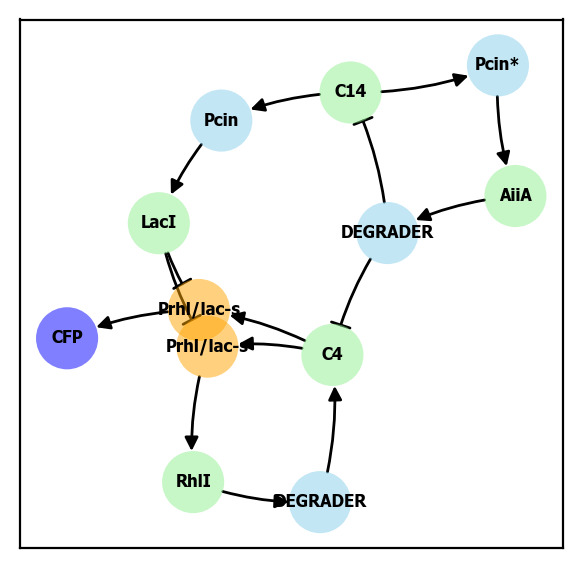

In [4]:
plt.figure(figsize=(3.5,3.5), dpi=200)
activator.draw() #pos=nx.planar_layout

Next, add circuit to strain with defined metabolism

In [5]:
def growth_rate(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab_act = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
activator_strain = lc.Strain(name="Activator", genetic_network=activator, metabolism=metab_act)

In [6]:
repressor = lc.GeneticNetwork()

degr_rate = 1.8*683.89*60*10**-9
cini = lc.Regulator(name='CinI', degradation_rate=degr_rate)
c4_r = lc.Regulator(name='C4', diffusion_rate=180)
aiia_r = lc.Regulator(name="AiiA", degradation_rate=degr_rate)
laci_r = lc.Regulator(name='LacI', degradation_rate=degr_rate)
yfp = lc.Reporter(name="YFP", degradation_rate=degr_rate, color='yellow')
c14_r = lc.Regulator(name='C14', diffusion_rate=126)

dr_cini = degr_rate * cini.concentration / (1300*10**-9) + aiia_r.concentration + laci_r.concentration + yfp.concentration
cini = lc.Regulator(name='CinI', degradation_rate=dr_cini)

dr_aiia_r = degr_rate * aiia_r.concentration / (1300*10**-9) + cini.concentration + laci_r.concentration + yfp.concentration
aiia_r = lc.Regulator(name="AiiA", degradation_rate=dr_aiia_r)

dr_laci_r = degr_rate * laci_r.concentration / (1300*10**-9) + cini.concentration + aiia_r.concentration + yfp.concentration
laci_r = lc.Regulator(name='LacI', degradation_rate=dr_laci_r)

dr_yfp = degr_rate * yfp.concentration / (1300*10**-9) + cini.concentration + aiia_r.concentration + laci_r.concentration
yfp = lc.Reporter(name="YFP", degradation_rate=dr_yfp, color='yellow')


repressor.add_regulator([cini, c4_r, aiia_r, laci_r, c14_r])
repressor.add_reporter(yfp)

# TODO: find a, K and n
c14_aiia_r = lc.Hill1(c14_r, aiia_r, alpha=[27.03 * 15.108 *60* 10**-9, 141.61 * 15.108 *60* 10**-9], K=594.23*10**-9, n=4, name='Pcin*')
c14_laci_r = lc.Hill1(c14_r, laci_r, alpha=[8.36 *60* 10**-9, 1735.47 * 8.36 *60* 10**-9], K=2357.3*10**-9, n=4, name='Pcin')

aiia_deg_ahls_r = lc.Degrader(enzyme=aiia_r, substrate=[c14_r, c4_r], Km=5510*10**-6, k2=135420, mode='papers')

c14_laci_yfp = lc.Hill2(input=[c14_r, laci_r], output=yfp, alpha=[41.8*7.723*60*10**-9, 197.49*7.723*60*10**-9, 0, 0], K=[594.23*10**-9, 47*10**-9], n=[4, 2], name='Pcin/lac')
c4_laci_cini = lc.Hill2(input=[c4_r, laci_r], output=cini, alpha=[20.13*10.423*60*10**-9, 367.48*10.423*60*10**-9, 0, 0], K=[5937*10**-9, 47.7*10**-9], n=[4, 2], name='Prhl/lac-s')

cini_c14 = lc.Producer(enzyme=cini, product=c14_r, k2=120)

repressor.add_operator([c14_aiia_r, c14_laci_r, c14_laci_yfp, c4_laci_cini])
repressor.add_impactor([aiia_deg_ahls_r, cini_c14])

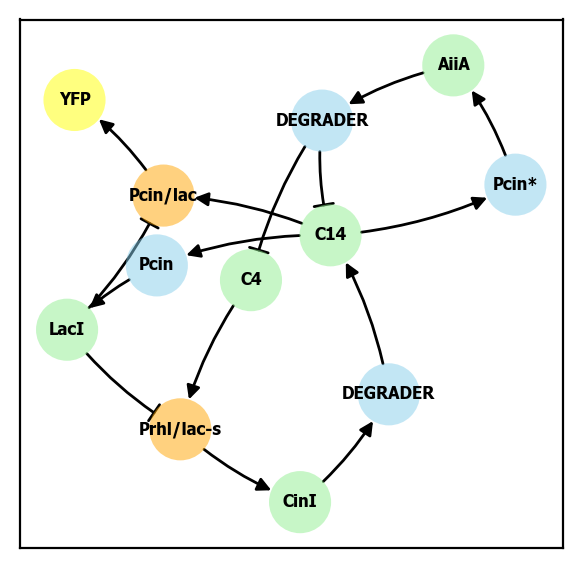

In [7]:
plt.figure(figsize=(3.5,3.5), dpi=200)
repressor.draw() #pos=nx.planar_layout

Next, add circuit to strain with defined metabolism

In [8]:
metab_rep = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
repressor_strain = lc.Strain(name="Repressor", genetic_network=repressor, metabolism=metab_rep)

In [9]:
sample = lc.Sample(strain=[activator_strain, repressor_strain])
assay = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='Chen consortium',
                description='Simulated YFP and GFP expression of consortium by Chen et al. (2015)'
                )

In [10]:
assay.run(substeps=50, stochastic=False, mode="track_all")

100%|██████████| 100.0/100 [01:25<00:00,  1.17it/s]


Text(0, 0.5, 'Concentration (M)')

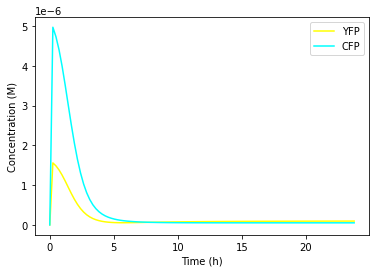

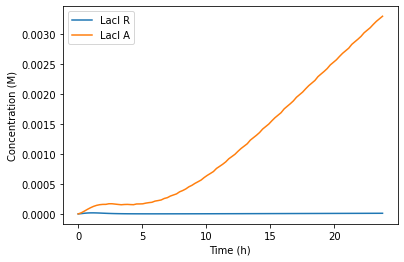

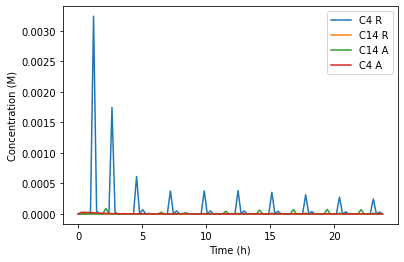

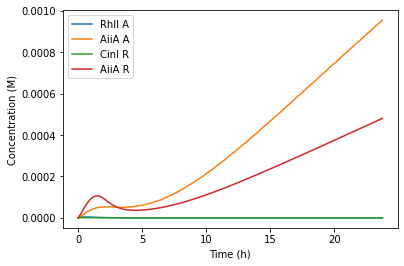

In [14]:
m = assay.measurements
# fig,(ax, ax1, ax2) = plt.subplots(3,1, sharex=True)
fig,ax = plt.subplots()
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()
m[m.Signal=='YFP in Repressor'].plot(x='Time', y='Measurement', color='yellow', style='-', ax=ax)
m[m.Signal=='CFP in Activator'].plot(x='Time', y='Measurement', color='cyan', style='-', ax=ax)

m[m.Signal=='LacI in Repressor'].plot(x='Time', y='Measurement', style='-', ax=ax1)
m[m.Signal=='LacI in Activator'].plot(x='Time', y='Measurement', style='-', ax=ax1)

m[m.Signal=='C4 in Repressor'].plot(x='Time', y='Measurement', style='-', ax=ax2)
m[m.Signal=='C14 in Repressor'].plot(x='Time', y='Measurement', style='-', ax=ax2)
m[m.Signal=='C14 in Activator'].plot(x='Time', y='Measurement', style='-', ax=ax2)
m[m.Signal=='C4 in Activator'].plot(x='Time', y='Measurement', style='-', ax=ax2)

m[m.Signal=='RhlI in Activator'].plot(x='Time', y='Measurement', style='-', ax=ax3)
m[m.Signal=='AiiA in Activator'].plot(x='Time', y='Measurement', style='-', ax=ax3)
m[m.Signal=='CinI in Repressor'].plot(x='Time', y='Measurement', style='-', ax=ax3)
m[m.Signal=='AiiA in Repressor'].plot(x='Time', y='Measurement', style='-', ax=ax3)

ax.legend(['YFP', 'CFP'])
ax.set_xlabel('Time (h)')
ax.set_ylabel('Concentration (M)')
ax1.legend(['LacI R', 'LacI A'])
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (M)')
ax2.legend(['C4 R', 'C14 R', 'C14 A', 'C4 A'])
ax2.set_xlabel('Time (h)')
ax2.set_ylabel('Concentration (M)')
ax3.legend(['RhlI A', 'AiiA A', 'CinI R', 'AiiA R'])
ax3.set_xlabel('Time (h)')
ax3.set_ylabel('Concentration (M)')

## P1N2

In [ ]:
activator = lc.GeneticNetwork()

# TODO: determine degr rate
rhli = lc.Regulator(name='RhlI')
c4 = lc.Regulator(name='C4', diffusion_rate=1)
aiia = lc.Regulator(name="AiiA", degradation_rate=0)
laci = lc.Regulator(name='LacI', degradation_rate=1)
cfp = lc.Reporter(name="CFP", degradation_rate=1, color='green')
c14 = lc.Regulator(name='C14', diffusion_rate=1)

activator.add_regulator([rhli, c4, aiia, laci, c14])
activator.add_reporter(cfp)

# TODO: find a, K and n
c14_aiia = lc.Hill1(c14, aiia, a=[1, 100], K=10, n=2, name='Pcin')
c14_laci = lc.Hill1(c14, laci, a=[1, 100], K=10, n=2, name='Pcin')

aiia_deg_ahls = lc.Degrader(enzyme=aiia, substrate=[c14, c4], Km=1, k2=3)

laci_cfp = lc.Hill1(laci, cfp, a=[100, 1], K=10, n=2, name='Plac')
laci_rhli = lc.Hill1(laci, rhli, a=[100, 1], K=10, n=2, name='Plac')

rhli_c4 = lc.Producer(enzyme=rhli, product=c4, k2=1)

activator.add_operator([c14_aiia, c14_laci, laci_cfp, laci_rhli])
activator.add_impactor([aiia_deg_ahls, rhli_c4])

In [ ]:
plt.figure(figsize=(3.5,3.5), dpi=200)
activator.draw(pos=nx.planar_layout)

Next, add circuit to strain with defined metabolism

In [ ]:
def growth_rate(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab_act = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
activator_strain = lc.Strain(name="Activator", genetic_network=activator, metabolism=metab_act)

In [ ]:
repressor = lc.GeneticNetwork()

# TODO: determine degr rate
cini = lc.Regulator(name='CinI')
c4_r = lc.Regulator(name='C4', diffusion_rate=1)
aiia_r = lc.Regulator(name="AiiA", degradation_rate=0)
laci_r = lc.Regulator(name='LacI', degradation_rate=1)
yfp = lc.Reporter(name="YFP", degradation_rate=1, color='green')
c14_r = lc.Regulator(name='C14', diffusion_rate=1)

repressor.add_regulator([cini, c4_r, aiia_r, laci_r, c14_r])
repressor.add_reporter(yfp)

# TODO: find a, K and n
c14_aiia_r = lc.Hill1(c14_r, aiia_r, a=[1, 100], K=10, n=2, name='Pcin')
c14_laci_r = lc.Hill1(c14_r, laci_r, a=[1, 100], K=10, n=2, name='Pcin')

aiia_deg_c14_r = lc.Degrader(enzyme=aiia_r, substrate=c14_r, k1=1, k1r=1, k2=3)
aiia_deg_c4_r = lc.Degrader(enzyme=aiia_r, substrate=c4_r, k1=1, k1r=1, k2=3)
# or
aiia_deg_ahls_r = lc.Degrader(enzyme=aiia_r, substrate=[c14_r, c4_r], k1=1, k1r=1, k2=3)

c14_laci_yfp = lc.Hill2(input=[c14_r, laci_r], output=yfp, alpha=[0.1, 100, 0.1, 0.1], K=[10, 10], n=[2, 2], name='Pcin/lac')
c14_laci_cini = lc.Hill2(input=[c14_r, laci_r], output=cini, alpha=[0.1, 100, 0.1, 0.1], K=[10, 10], n=[2, 2], name='Pcin/lac')

cini_c14 = lc.Producer(enzyme=cini, product=c14_r, rate=1)

repressor.add_operator([c14_aiia_r, c14_laci_r, aiia_deg_c14_r, aiia_deg_c4_r, c14_laci_yfp, c14_laci_cini, cini_c14])

In [ ]:
plt.figure(figsize=(3.5,3.5), dpi=200)
repressor.draw(pos=nx.planar_layout)

Next, add circuit to strain with defined metabolism

In [ ]:
metab_rep = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
repressor_strain = lc.Strain(name="Repressor", genetic_network=repressor, metabolism=metab_rep)

In [ ]:
sample = lc.Sample(strain=[activator_strain, repressor_strain])
assay = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='Quorum clock',
                description='Simulated GFP expression of quorum clock by Danino et al. (2010)'
                )

In [ ]:
assay.run(stochastic=False, track_all=True)

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
# TODO: rewrite
# m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='AHL in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='yemGFP in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='AiiA in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='E. coli biomass'].plot(x='Time', y='Measurement', style='-', ax=ax)
# plt.legend(['Extracellular AHL', 'Internal AHL', 'GFP', 'AiiA', 'Biomass'])

## P2N1

In [ ]:
activator = lc.GeneticNetwork()

# TODO: determine degr rate
rhli = lc.Regulator(name='RhlI')
c4 = lc.Regulator(name='C4', diffusion_rate=1)
aiia = lc.Regulator(name="AiiA", degradation_rate=0)
laci = lc.Regulator(name='LacI', degradation_rate=1)
cfp = lc.Reporter(name="CFP", degradation_rate=1, color='green')
c14 = lc.Regulator(name='C14', diffusion_rate=1)

activator.add_regulator([rhli, c4, aiia, laci, c14])
activator.add_reporter(cfp)

# TODO: find a, K and n
c14_aiia = lc.Hill1(c14, aiia, a=[1, 100], K=10, n=2, name='Pcin')
c14_laci = lc.Hill1(c14, laci, a=[1, 100], K=10, n=2, name='Pcin')

aiia_deg_c14 = lc.Degrader(enzyme=aiia, substrate=c14, k1=1, k1r=1, k2=3)
aiia_deg_c4 = lc.Degrader(enzyme=aiia, substrate=c4, k1=1, k1r=1, k2=3)
# or
aiia_deg_ahls = lc.Degrader(enzyme=aiia, substrate=[c14, c4], k1=1, k1r=1, k2=3)

c4_laci_cfp = lc.Hill2(input=[c4, laci], output=cfp, alpha=[0.1, 100, 0.1, 0.1], K=[10, 10], n=[2, 2], name='Prhl/lac')
c4_laci_rhli = lc.Hill2(input=[c4, laci], output=rhli, alpha=[0.1, 100, 0.1, 0.1], K=[10, 10], n=[2, 2], name='Prhl/lac')

rhli_c4 = lc.Producer(enzyme=rhli, product=c4, rate=1)

activator.add_operator([c14_aiia, c14_laci, aiia_deg_c14, aiia_deg_c4, c4_laci_cfp, c4_laci_rhli, rhli_c4])

In [ ]:
plt.figure(figsize=(3.5,3.5), dpi=200)
activator.draw(pos=nx.planar_layout)

Next, add circuit to strain with defined metabolism

In [ ]:
def growth_rate(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab_act = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
activator_strain = lc.Strain(name="Activator", genetic_network=activator, metabolism=metab_act)

In [ ]:
repressor = lc.GeneticNetwork()

# TODO: determine degr rate
cini = lc.Regulator(name='CinI')
c4_r = lc.Regulator(name='C4', diffusion_rate=1)
aiia_r = lc.Regulator(name="AiiA", degradation_rate=0)
yfp = lc.Reporter(name="YFP", degradation_rate=1, color='green')
c14_r = lc.Regulator(name='C14', diffusion_rate=1)

repressor.add_regulator([cini, c4_r, aiia_r, c14_r])
repressor.add_reporter(yfp)

# TODO: find a, K and n
c14_aiia_r = lc.Hill1(c14_r, aiia_r, a=[1, 100], K=10, n=2, name='Pcin')

aiia_deg_c14_r = lc.Degrader(enzyme=aiia_r, substrate=c14_r, k1=1, k1r=1, k2=3)
aiia_deg_c4_r = lc.Degrader(enzyme=aiia_r, substrate=c4_r, k1=1, k1r=1, k2=3)
# or
aiia_deg_ahls_r = lc.Degrader(enzyme=aiia_r, substrate=[c14_r, c4_r], k1=1, k1r=1, k2=3)

c14_yfp = lc.Hill1(c14_r, yfp, a=[1, 100], K=10, n=2, name='Pcin/lac')
c4_cini = lc.Hill1(c4_r, cini, a=[1, 100], K=10, n=2, name='Prhl/lac')

cini_c14 = lc.Producer(enzyme=cini, product=c14_r, rate=1)

repressor.add_operator([c14_aiia_r, aiia_deg_c14_r, aiia_deg_c4_r, c14_yfp, c4_cini, cini_c14])

In [ ]:
plt.figure(figsize=(3.5,3.5), dpi=200)
repressor.draw(pos=nx.planar_layout)

Next, add circuit to strain with defined metabolism

In [ ]:
metab_rep = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
repressor_strain = lc.Strain(name="Repressor", genetic_network=repressor, metabolism=metab_rep)

In [ ]:
sample = lc.Sample(strain=[activator_strain, repressor_strain])
assay = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='Quorum clock',
                description='Simulated GFP expression of quorum clock by Danino et al. (2010)'
                )

In [ ]:
assay.run(stochastic=False, track_all=True)

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
# TODO: rewrite
# m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='AHL in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='yemGFP in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='AiiA in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='E. coli biomass'].plot(x='Time', y='Measurement', style='-', ax=ax)
# plt.legend(['Extracellular AHL', 'Internal AHL', 'GFP', 'AiiA', 'Biomass'])

## P1N1

In [ ]:
activator = lc.GeneticNetwork()

# TODO: determine degr rate
rhli = lc.Regulator(name='RhlI')
c4 = lc.Regulator(name='C4', diffusion_rate=1)
aiia = lc.Regulator(name="AiiA", degradation_rate=0)
laci = lc.Regulator(name='LacI', degradation_rate=1)
cfp = lc.Reporter(name="CFP", degradation_rate=1, color='green')
c14 = lc.Regulator(name='C14', diffusion_rate=1)

activator.add_regulator([rhli, c4, aiia, laci, c14])
activator.add_reporter(cfp)

# TODO: find a, K and n
c14_aiia = lc.Hill1(c14, aiia, a=[1, 100], K=10, n=2, name='Pcin')
c14_laci = lc.Hill1(c14, laci, a=[1, 100], K=10, n=2, name='Pcin')

aiia_deg_c14 = lc.Degrader(enzyme=aiia, substrate=c14, k1=1, k1r=1, k2=3)
aiia_deg_c4 = lc.Degrader(enzyme=aiia, substrate=c4, k1=1, k1r=1, k2=3)
# or
aiia_deg_ahls = lc.Degrader(enzyme=aiia, substrate=[c14, c4], k1=1, k1r=1, k2=3)

laci_cfp = lc.Hill1(laci, cfp, a=[100, 1], K=10, n=2, name='Plac')
laci_rhli = lc.Hill1(laci, rhli, a=[100, 1], K=10, n=2, name='Plac')

rhli_c4 = lc.Producer(enzyme=rhli, product=c4, rate=1)

activator.add_operator([c14_aiia, c14_laci, aiia_deg_c14, aiia_deg_c4, laci_cfp, laci_rhli, rhli_c4])

In [ ]:
plt.figure(figsize=(3.5,3.5), dpi=200)
activator.draw(pos=nx.planar_layout)

Next, add circuit to strain with defined metabolism

In [ ]:
def growth_rate(t):
    return lc.gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return lc.gompertz(t, 0.01, 1, 1, 1)

metab_act = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
activator_strain = lc.Strain(name="Activator", genetic_network=activator, metabolism=metab_act)

In [ ]:
repressor = lc.GeneticNetwork()

# TODO: determine degr rate
cini = lc.Regulator(name='CinI')
c4_r = lc.Regulator(name='C4', diffusion_rate=1)
aiia_r = lc.Regulator(name="AiiA", degradation_rate=0)
yfp = lc.Reporter(name="YFP", degradation_rate=1, color='green')
c14_r = lc.Regulator(name='C14', diffusion_rate=1)

repressor.add_regulator([cini, c4_r, aiia_r, c14_r])
repressor.add_reporter(yfp)

# TODO: find a, K and n
c14_aiia_r = lc.Hill1(c14_r, aiia_r, a=[1, 100], K=10, n=2, name='Pcin')

aiia_deg_c14_r = lc.Degrader(enzyme=aiia_r, substrate=c14_r, k1=1, k1r=1, k2=3)
aiia_deg_c4_r = lc.Degrader(enzyme=aiia_r, substrate=c4_r, k1=1, k1r=1, k2=3)
# or
aiia_deg_ahls_r = lc.Degrader(enzyme=aiia_r, substrate=[c14_r, c4_r], k1=1, k1r=1, k2=3)

c14_yfp = lc.Hill1(c14_r, yfp, a=[1, 100], K=10, n=2, name='Pcin/lac')
c4_cini = lc.Hill1(c4_r, cini, a=[1, 100], K=10, n=2, name='Prhl/lac')

cini_c14 = lc.Producer(enzyme=cini, product=c14_r, rate=1)

repressor.add_operator([c14_aiia_r, aiia_deg_c14_r, aiia_deg_c4_r, c14_yfp, c4_cini, cini_c14])

In [ ]:
plt.figure(figsize=(3.5,3.5), dpi=200)
repressor.draw(pos=nx.planar_layout)

Next, add circuit to strain with defined metabolism

In [ ]:
metab_rep = lc.SimulatedMetabolism("Simulated metabolism", biomass, growth_rate)
repressor_strain = lc.Strain(name="Repressor", genetic_network=repressor, metabolism=metab_rep)

In [ ]:
sample = lc.Sample(strain=[activator_strain, repressor_strain])
assay = lc.Assay([sample], 
                n_measurements=100, 
                interval=0.24,
                name='Quorum clock',
                description='Simulated GFP expression of quorum clock by Danino et al. (2010)'
                )

In [ ]:
assay.run(stochastic=False, track_all=True)

In [ ]:
m = assay.measurements
fig,ax = plt.subplots(1,1)
# TODO: rewrite
# m[m.Signal=='Extracellular C14'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='AHL in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='yemGFP in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='AiiA in E. coli'].plot(x='Time', y='Measurement', style='-', ax=ax)
# m[m.Signal=='E. coli biomass'].plot(x='Time', y='Measurement', style='-', ax=ax)
# plt.legend(['Extracellular AHL', 'Internal AHL', 'GFP', 'AiiA', 'Biomass'])